## Colecting Data from Youtube API
- Pull the data from an API
- Look through the JSON response
- Save the data collected in a Local PostgreSQL Database
- Cleaning, filtering and visualizing the data

In [1]:
#importing libraries
import requests #to make API calls
import pandas as pd
import time

In [2]:
#Keys
API_KEY ='xxxxxx'
CHANNEL_ID = 'UC8butISFwT-Wl7EV0hUK0BQ' #from freeCodeCamp youtube channel

### First API call:
- Pulling data such as video id, title and upload date.

In [3]:
#Making an API call
# setting the deafault results per page (5).

pageToken = None
params = {'key': API_KEY, 'channelId': CHANNEL_ID, 'part' : 'snippet', 'order' : 'date', 'pageToken' : pageToken}

url = 'https://www.googleapis.com/youtube/v3/search'
response = requests.get(url, params=params).json()

In [ ]:
#The information that I need are in items key
response['items']

#### Parsing through the Data

In [5]:
#getting the info for the first video

video_id = response['items'][0]['id']['videoId']
print(video_id)

video_title = response['items'][0]['snippet']['title']
video_title = str(video_title).replace('&#39;', "'") #replace the Apostroph string
print(video_title)

upload_date = response['items'][0]['snippet']['publishedAt']
upload_date = str(upload_date).split('T')[0] #getting only the date, not the timestamp
print(upload_date)

M3ZWfamWrBM
PyTorch and Monai for AI Healthcare Imaging - Python Machine Learning Course
2022-01-06


### Second API call:
- Pulling metric data such as number of views, likes and comments

In [6]:
#First, let's test for the first video id:

first_video_id = 'M3ZWfamWrBM'
params = {'key': API_KEY, 'id': first_video_id, 'part' : 'statistics'}

url_video_stats = 'https://www.googleapis.com/youtube/v3/videos'
response_video_stats = requests.get(url_video_stats, params=params).json()

In [7]:
#Here what I want to grab

response_video_stats['items'][0]['statistics']

{'viewCount': '26065',
 'likeCount': '1398',
 'favoriteCount': '0',
 'commentCount': '38'}

In [8]:
view_count = response_video_stats['items'][0]['statistics']['viewCount']
like_count = response_video_stats['items'][0]['statistics']['likeCount']
comment_count = response_video_stats['items'][0]['statistics']['commentCount']
print(view_count)
print(like_count)
print(comment_count)

26065
1398
38


### Combining both API calls

In [9]:
#as we get the video_title for each video, we will pass it for the second call to get the statistics(views, likes and comment)

def get_videos_details(video_id): 
    params = {'key': API_KEY, 'id': video_id, 'part' : 'statistics'}
    url_video_stats = 'https://www.googleapis.com/youtube/v3/videos'
    response_video_stats = requests.get(url_video_stats, params=params).json()

    view_count = response_video_stats['items'][0]['statistics']['viewCount']
    like_count = response_video_stats['items'][0]['statistics']['likeCount']
    comment_count = response_video_stats['items'][0]['statistics']['commentCount']
    
    return view_count, like_count, comment_count

In [10]:
def get_videos(df, list_tokens):
    #Make the first API call
    pageToken = None
    
    while True:
        params = {'key': API_KEY, 'channelId': CHANNEL_ID, 'part' : 'snippet', 'order' : 'date', 'pageToken' : pageToken}
        url = 'https://www.googleapis.com/youtube/v3/search'
        response = requests.get(url, params=params).json()

        time.sleep(1) #wait for a second to ensure the request response is already done before going to the for loop.

        #Using this in case we got an error message for limit requests and then, it will not find 'items' in response!
        try:
            videos = response['items'] #it contains all video info
        except Exception as e:
            print(e)
            break

        for video in videos:
            video_id = video['id']['videoId']

            video_title = video['snippet']['title']
            video_title = str(video_title).replace('&#39;', "'") #replace the Apostroph string

            upload_date = video['snippet']['publishedAt']
            upload_date = str(upload_date).split('T')[0] #getting only the date, not the timestamp (Year - Month - Day)

            #calling the function defined above (second API call) and returning those metrics:
            try:
                view_count, like_count, comment_count = get_videos_details(video_id)
            except Exception as e:
                print(e)
                break

            #save the data into df row by row in each column
            df = df.append({"video_id" : video_id,"video_title" : video_title,"upload_date" : upload_date
                            ,"view_count" : view_count,"like_count" : like_count,
                            "comment_count" : comment_count}, ignore_index=True)
        
        #After getting all the videos details, it has to grab the nextPageToken to go to the other page and do the same.
        #if none, it means it reached the last page and break out of it.
        
        try:
            if (response['nextPageToken'] != None) or (response['nextPageToken'] != ''): #if none, it means it reached the last page and break out of it
                pageToken = str(response['nextPageToken'])

        except Exception as e:
            print(e)
            break

        #appending all the PageTokens for the pages we extract the data to track it for the next call (in case we ran out of requests).
        list_tokens.append(response['nextPageToken'])

    return df, list_tokens

In [11]:
# Main

list_tokens = []

# Create an empty df with 6 columns
df= pd.DataFrame(columns=["video_id","video_title","upload_date","view_count","like_count","comment_count"])

# Calling the function, given an empty df and returning a df with all info.
df, list_tokens = get_videos(df, list_tokens)

'nextPageToken'


In [12]:
df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,jwCmIBJ8Jtc,Figma Tutorial for UI Design - Course for Begi...,2022-01-05,55000,2488,151
1,025QFeZfeyM,Code a 2D Game Engine using Java - Full Course...,2022-01-03,139575,6315,424
2,b_IDdQzPRR4,Learn to Code RPG - A freeCodeCamp.org Game [p...,2021-12-22,122505,3206,98
3,erka8USiBgM,Build a CRM with Google Sheets + PostgreSQL + ...,2021-12-21,278634,6558,262
4,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125070,4886,177


In [13]:
df.shape

(420, 6)

In [14]:
print(list_tokens[-1])

CKQDEAA


In [22]:
pageToken = 'CKQDEAA'
params = {'key': API_KEY, 'channelId': CHANNEL_ID, 'part' : 'snippet', 'order' : 'date', 'pageToken' : pageToken}

url = 'https://www.googleapis.com/youtube/v3/search'
response = requests.get(url, params=params).json()

In [25]:
response

{'kind': 'youtube#searchListResponse',
 'etag': 'RyNdWcV-hCiK4M4BPfJCE-xAJyY',
 'prevPageToken': 'CKQDEAE',
 'regionCode': 'DE',
 'pageInfo': {'totalResults': 1424, 'resultsPerPage': 1},
 'items': [{'kind': 'youtube#searchResult',
   'etag': 'kflPJhN_-_rUgPOIk0YSiVIUDIo',
   'id': {'kind': 'youtube#video', 'videoId': 'vJZf48t_OEI'},
   'snippet': {'publishedAt': '2017-08-10T20:37:56Z',
    'channelId': 'UC8butISFwT-Wl7EV0hUK0BQ',
    'title': 'React Project 2 Day 16 - Live Coding with Jesse',
    'description': 'Day 16 of the new React project. Today I am continuing to work on the masonry layout of the logo download section.',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/vJZf48t_OEI/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/vJZf48t_OEI/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/vJZf48t_OEI/hqdefault.jpg',
      'width': 480,
      'height': 360}},
   

#### Although the freeCodeCamp youtube channel has 1424 videos, at some point it did not provide the nextPageToken, so it extracted only 420 records.

### Upload this data to a database:
- Store the data in the Local SQL Server database

In [26]:
import psycopg2 as ps #to connect to a PostgreSQL database from Python

In [27]:
#creating the connection function
def connect_to_db(host_name, data_base, user_name, password, port_id):
    try:
        conn = ps.connect(host = host_name, database = data_base, user = user_name, password = password, port = port_id)
    except ps.OperationalError as e:
        raise e
    else:
        print('Connected sucessfully!')
    
    return conn

In [28]:
# credentials for the local database in my machine
host_name = 'localhost'
data_base = 'postgres'
user_name = 'postgres'
password = 'xxxxxx'
port_id = '5432'
conn = None

In [29]:
conn = connect_to_db(host_name, data_base, user_name, password, port_id)

Connected sucessfully!


#### Creating the db table

In [30]:
def create_table(curr):
    create_table_command = (''' CREATE TABLE IF NOT EXISTS youtube_videos_freecodecamp (
                                video_id VARCHAR (300) PRIMARY KEY,
                                video_title TEXT NOT NULL,
                                upload_date DATE NOT NULL DEFAULT CURRENT_DATE,
                                view_count INT NOT NULL,
                                like_count INT NOT NULL,
                                comment_count INT NOT NULL
                            );''')
    curr.execute(create_table_command)

In [31]:
#creating the cursor to execute the SQL commands
curr = conn.cursor()

In [32]:
create_table(curr)

In [33]:
conn.commit()

#### Loading the data to the database table:
- video id, title and upload date are records that are never going to be changed/updated.
- view, like and comment counts update every time we pull new data from the API.

In [34]:
df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,jwCmIBJ8Jtc,Figma Tutorial for UI Design - Course for Begi...,2022-01-05,55000,2488,151
1,025QFeZfeyM,Code a 2D Game Engine using Java - Full Course...,2022-01-03,139575,6315,424
2,b_IDdQzPRR4,Learn to Code RPG - A freeCodeCamp.org Game [p...,2021-12-22,122505,3206,98
3,erka8USiBgM,Build a CRM with Google Sheets + PostgreSQL + ...,2021-12-21,278634,6558,262
4,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125070,4886,177


In [35]:
#check if the video id from the db match the video id from the df.

def check_video_exists(curr, video_id):
    query_select = ('''SELECT video_id FROM youtube_videos_freecodecamp WHERE video_id = %s;''')
    
    #To generate a one-element tuple, a comma , is required at the end.
    variable = (video_id,) #the variable that come from the df and goes to the sql query
    
    curr.execute(query_select, variable)
    record = curr.fetchone() #returns a single record or None if there is no row available.
    
    if record is not None: #it executes only if there is record (the video already exists)
        return record
    else:
        return False

In [36]:
# The update row function.
def update_row(curr, video_id, view_count, like_count, comment_count):
    query_update = ('''UPDATE youtube_videos_freecodecamp
                    SET view_count = %s,
                    like_count = %s,
                    comment_count = %s
                    WHERE video_id = %s;''')

    variables = (view_count, like_count, comment_count, video_id) #the variables that come from the df and go to the sql query
    curr.execute(query_update, variables)

In [37]:
#Defining the function which will update the database inserting new records and/or updating the metrics

def update_database(curr, df):
    # Create a new empty df exactly before, which we will append the rows which never were stored in the database (for the first time, all records will be stored here since there are any records)
    new_videos_df = pd.DataFrame(columns=["video_id","video_title","upload_date","view_count","like_count","comment_count"])

    for i, row in df.iterrows():
        if check_video_exists(curr, row['video_id']): #if it is true, it will run the update_row function to refresh the view, like and comment counts
            update_row(curr, row['video_id'], row['view_count'], row['like_count'], row['comment_count'])
        else: #if the video does not exist, it will append to the db table
            new_videos_df = new_videos_df.append(row)
    
    return new_videos_df

In [38]:
new_videos_df = update_database(curr, df)

In [39]:
#as expected, all the records were appended to the new empty df because there is no records in the database so far.
new_videos_df.shape

(420, 6)

In [41]:
#Defing the function to insert new records to the table database

def insert_new_videos(curr, video_id, video_title, upload_date, view_count, like_count, comment_count):
    query_insert_new_videos = ('''INSERT INTO youtube_videos_freecodecamp
                                (video_id, video_title, upload_date, view_count, like_count, comment_count)
                                VALUES (%s, %s, %s, %s, %s, %s);''')

    variables_insert = (video_id, video_title, upload_date, view_count, like_count, comment_count)
    curr.execute(query_insert_new_videos, variables_insert)

In [42]:
#Creating the function to go row by row in order to insert the new records

def append_from_df_to_db(curr, df):
    for i, row in df.iterrows():
        insert_new_videos(curr, row['video_id'], row['video_title'], row['upload_date'], row['view_count'], row['like_count'], row['comment_count'])

#### Calling the function to append the new_videos_df to the database table.

In [43]:
#Since I defined video_id as PRIMARY KEY and I extracted some duplicated videos from the API call, I must drop them.

new_videos_df[new_videos_df.duplicated(['video_id'], keep = 'first')].head()

,video_id,video_title,upload_date,view_count,like_count,comment_count
5,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125073,4886,177
50,j7VZsCCnptM,Selenium Course for Beginners - Web Scraping B...,2021-08-31,177982,5207,186
65,K2qjAixgLqk,Reinforcement Learning Course: Intro to Advanc...,2021-07-30,46673,1318,46
115,0B5eIE_1vpU,Scikit-learn Crash Course - Machine Learning L...,2021-04-07,86285,2886,99
145,sfmL6bGbiN8,Build a Shopping Cart with React and TypeScrip...,2021-01-21,129253,3736,183


In [44]:
df.loc[df['video_id'] == '47NRaBVxgVM']

,video_id,video_title,upload_date,view_count,like_count,comment_count
4,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125070,4886,177
5,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125073,4886,177


In [45]:
def drop_duplicates(df):
    
    if df[df.duplicated(['video_id'], keep = 'first')] is not None:
        df.drop_duplicates(subset=['video_id'], keep="first", inplace=True)
    
    return df

In [46]:
new_videos_df = drop_duplicates(new_videos_df)

In [47]:
new_videos_df.shape

(401, 6)

In [48]:
append_from_df_to_db(curr, new_videos_df)

In [49]:
conn.commit()

#### Load the database table to df in order to:
- Manipulate and do some analysis

In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [164]:
videos_df = pd.read_sql('SELECT * FROM youtube_videos_freecodecamp', con=conn)

In [165]:
videos_df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,jwCmIBJ8Jtc,Figma Tutorial for UI Design - Course for Begi...,2022-01-05,55000,2488,151
1,025QFeZfeyM,Code a 2D Game Engine using Java - Full Course...,2022-01-03,139575,6315,424
2,b_IDdQzPRR4,Learn to Code RPG - A freeCodeCamp.org Game [p...,2021-12-22,122505,3206,98
3,erka8USiBgM,Build a CRM with Google Sheets + PostgreSQL + ...,2021-12-21,278634,6558,262
4,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125070,4886,177


In [388]:
# Creating the images folder for saving the graphs later

image_path = './images/'
if not os.path.exists(image_path):
    os.makedirs(image_path)

#### Let's visualize the average view in the youtube videos by month and year

In [166]:
videos_df['Month'] = pd.to_datetime(videos_df['upload_date']).dt.strftime('%b')
videos_df['Year'] = pd.to_datetime(videos_df['upload_date']).dt.strftime('%Y')

In [167]:
videos_df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count,Month,Year
0,jwCmIBJ8Jtc,Figma Tutorial for UI Design - Course for Begi...,2022-01-05,55000,2488,151,Jan,2022
1,025QFeZfeyM,Code a 2D Game Engine using Java - Full Course...,2022-01-03,139575,6315,424,Jan,2022
2,b_IDdQzPRR4,Learn to Code RPG - A freeCodeCamp.org Game [p...,2021-12-22,122505,3206,98,Dec,2021
3,erka8USiBgM,Build a CRM with Google Sheets + PostgreSQL + ...,2021-12-21,278634,6558,262,Dec,2021
4,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125070,4886,177,Dec,2021


In [168]:
videos_per_year = videos_df.groupby('Year', as_index=False).size()
videos_per_year

,Year,size
0,2017,1
1,2018,56
2,2019,77
3,2020,122
4,2021,143
5,2022,2


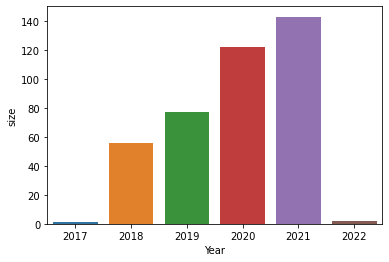

In [169]:
ax = sns.barplot(x='Year', y='size', data = videos_per_year)

In [170]:
#As it extracted only 1 video in 2017 and there are only 2 videos in 2022 so far, I will remove them
new_videos_df = videos_df[(videos_df['Year'] != '2017') & (videos_df['Year'] != '2022')]

In [171]:
new_videos_df['Year'].unique()

array(['2021', '2020', '2019', '2018'], dtype=object)

In [172]:
new_videos_df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count,Month,Year
2,b_IDdQzPRR4,Learn to Code RPG - A freeCodeCamp.org Game [p...,2021-12-22,122505,3206,98,Dec,2021
3,erka8USiBgM,Build a CRM with Google Sheets + PostgreSQL + ...,2021-12-21,278634,6558,262,Dec,2021
4,47NRaBVxgVM,"Internet History, Technology, and Security - F...",2021-12-20,125070,4886,177,Dec,2021
5,Hj_rA0dhr2I,Linked Lists for Technical Interviews - Full C...,2021-12-15,78153,2502,76,Dec,2021
6,F5KJVuii0Yw,Web App Vulnerabilities - DevSecOps Course for...,2021-12-14,76590,2589,51,Dec,2021


In [173]:
sort_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [174]:
new_videos_df.index = pd.CategoricalIndex(new_videos_df['Month'], categories=sort_order, ordered=True)

In [175]:
new_videos_df = new_videos_df.sort_index()

In [176]:
new_videos_df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count,Month,Year
Month,,,,,,,,
Jan,0Cvi6PBVS_U,Creating a Material Design Style Homepage (P5D...,2018-01-03,4115,85,0,Jan,2018
Jan,F0WoVEr0-44,Computational Thinking &amp; Scratch - Intro t...,2019-01-22,463257,8621,268,Jan,2019
Jan,ix5jPkxsr7M,C Programming Language - Intro to Computer Sci...,2019-01-23,519336,13153,385,Jan,2019
Jan,mudOTSUumXg,"HTTP, HTML, CSS - Intro to Computer Science - ...",2019-01-27,118882,3126,95,Jan,2019
Jan,TPMlZxRRaBQ,Tableau for Data Science and Data Visualizatio...,2019-01-29,506464,7504,154,Jan,2019


In [179]:
videos_df_pivot = pd.pivot_table(
            new_videos_df,
            values = 'view_count',
            index = 'Year',
            columns = new_videos_df.index,
            aggfunc=np.mean
        )

In [180]:
videos_df_pivot

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2018,4115.000000,3624.0,2471.000000,1.561539e+06,2.675200e+04,513636.571429,7.451566e+06,3.366304e+06,6.318586e+05,99491.400000,49007.333333,1.512537e+06
2019,292081.250000,129751.5,360658.571429,1.053574e+06,1.337864e+06,953851.125000,1.221787e+06,7.186030e+05,1.215923e+06,867665.000000,661792.000000,1.649925e+06
2020,NaN,445142.5,846750.500000,1.036938e+06,4.288988e+05,260007.250000,3.153059e+05,4.783576e+05,2.634769e+05,457485.545455,344005.733333,4.648163e+05
2021,375016.857143,259265.0,421850.166667,3.028468e+05,2.966973e+05,238978.666667,1.847097e+05,1.815814e+05,3.327069e+05,116005.333333,187930.000000,1.300996e+05


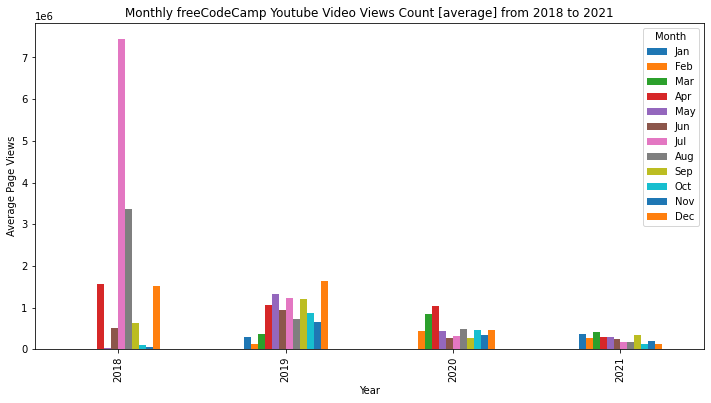

In [389]:
fig, ax = plt.subplots(figsize=(12, 6))
videos_df_pivot.plot(kind="bar", ax=ax)

ax.set_title("Monthly freeCodeCamp Youtube Video Views Count [average] from 2018 to 2021")
ax.set_xlabel("Year")
ax.set_ylabel("Average Page Views")

plt.show()
fig.savefig(image_path + 'monthly_freecodecamp_average_views.png')

#### According to this graph:
- The most popular videos released are from 2018, mainly the videos from July with more than 7 millions views.
- The recent videos (2021) are not as popular as the other ones, which may be people are not feeling interested in the content of those videos and/or opt to watch for another source.

In [196]:
new_videos_df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count,Month,Year
Month,,,,,,,,
Jan,0Cvi6PBVS_U,Creating a Material Design Style Homepage (P5D...,2018-01-03,4115,85,0,Jan,2018
Jan,F0WoVEr0-44,Computational Thinking &amp; Scratch - Intro t...,2019-01-22,463257,8621,268,Jan,2019
Jan,ix5jPkxsr7M,C Programming Language - Intro to Computer Sci...,2019-01-23,519336,13153,385,Jan,2019
Jan,mudOTSUumXg,"HTTP, HTML, CSS - Intro to Computer Science - ...",2019-01-27,118882,3126,95,Jan,2019
Jan,TPMlZxRRaBQ,Tableau for Data Science and Data Visualizatio...,2019-01-29,506464,7504,154,Jan,2019


#### Filtering the video title which contain Python

In [232]:
python_videos_related = new_videos_df[new_videos_df['video_title'].str.contains("Python")]

In [252]:
python_videos_related = python_videos_related.reset_index(drop=True)

In [278]:
python_videos_related[["view_count", 'like_count', 'comment_count']].mean().tolist()

[911465.1, 24303.64285714286, 1101.3857142857144]

In [343]:
#Create a function to get the mean of view, like and comment for each subject defined

def get_info_subjects(df, list_popular_subject):
    info_dict = {}
    
    for subject in list_popular_subject:
        df_subject = df[df['video_title'].str.contains(subject)]
        
        values = df_subject[['view_count', 'like_count', 'comment_count']].mean().tolist()
        round_values = [round(num, 2) for num in values]
        
        info_dict[subject] = round_values

    return info_dict

In [344]:
#calling the function
list_popular_subject = ['Data Analysis', 'Data Science', 'Machine Learning', 'Deep Learning', 'Computer Vision']

info_subject = get_info_subjects(python_videos_related, list_popular_subject)

In [353]:
subject_df = pd.DataFrame(info_subject, index = ['view_count', 'like_count', 'comment_count'])
subject_df

,Data Analysis,Data Science,Machine Learning,Deep Learning,Computer Vision
view_count,339739.22,1022962.0,191035.00,281521.5,239154.25
like_count,9295.67,29420.0,5853.00,7721.0,9886.00
comment_count,189.33,680.5,172.33,260.5,211.50


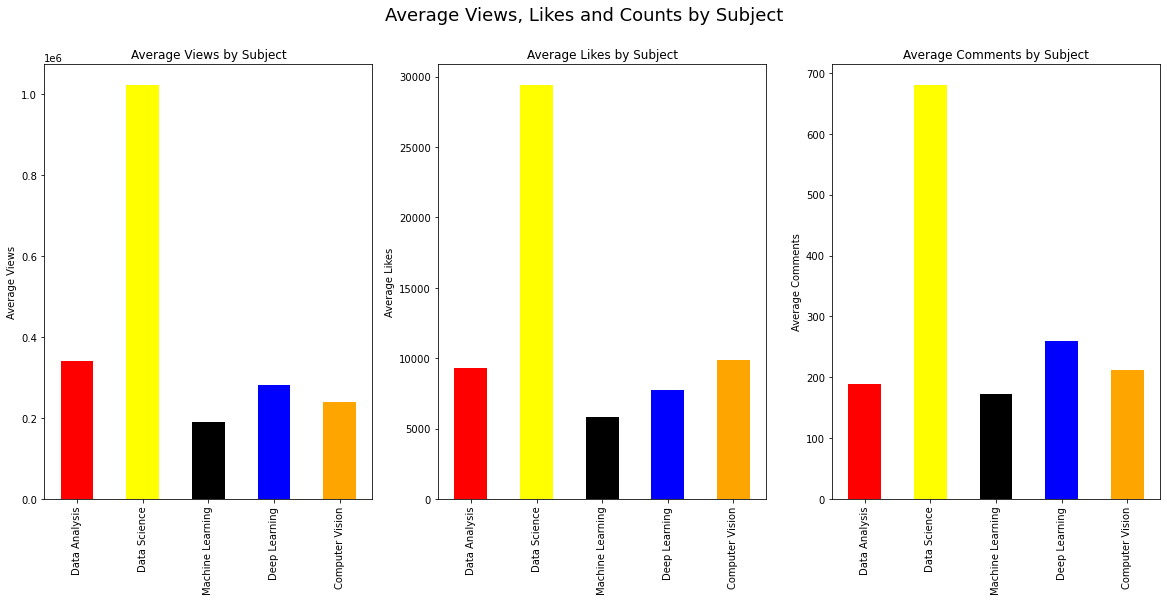

In [391]:
fig, axes = plt.subplots(1,3 , figsize=(20, 8))
fig.suptitle('Average Views, Likes and Counts by Subject', fontsize=18)
c = ['red', 'yellow', 'black', 'blue', 'orange']

#View
subject_df.loc['view_count'].plot(kind="bar", ax=axes[0], color = c)

axes[0].set_title("Average Views by Subject")
axes[0].set_ylabel("Average Views")


#Like
subject_df.loc['like_count'].plot(kind="bar", ax=axes[1], color = c)

axes[1].set_title("Average Likes by Subject")
axes[1].set_ylabel("Average Likes")

#Comment

subject_df.loc['comment_count'].plot(kind="bar", ax=axes[2], color = c)

axes[2].set_title("Average Comments by Subject")
axes[2].set_ylabel("Average Comments")


plt.show()
fig.savefig(image_path + 'average_by_subject.png', dpi = 300, bbox_inches="tight")

#### What type of content is the most watched from freeCodeCamp YouTube channel when it envolves Python?
This plot shows that the most popular content related with Python topic from freeCodeCamp Youtube channel are videos with Data Science as a subject/topic in the title.

In [65]:
curr.close()

In [66]:
conn.close()